In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
import statsmodels.formula.api as smf
%matplotlib inline

In [2]:
sentiment = pd.read_csv('consumer_sentiment.csv')

In [3]:
sentiment

,CASEID,YYYYMM,YYYYQ,YYYY,ID,IDPREV,DATEPR,ICS,ICC,ICE
0,1,197801,19781,1978,1,,,76.71,116.23,51.32
1,2,197801,19781,1978,2,,,121.12,154.08,99.94
2,3,197801,19781,1978,3,,,2.70,2.70,2.70
3,4,197801,19781,1978,4,,,76.71,154.08,27.01
4,5,197801,19781,1978,5,,,121.12,116.23,124.25
...,...,...,...,...,...,...,...,...,...,...
312726,312727,202307,20233,2023,2097,1130,202301,31.60,39.84,26.31
312727,312728,202307,20233,2023,2098,1038,202301,76.01,153.38,26.31
312728,312729,202307,20233,2023,2099,1141,202301,61.21,115.53,26.31
312729,312730,202307,20233,2023,2100,1071,202301,90.81,77.69,99.24


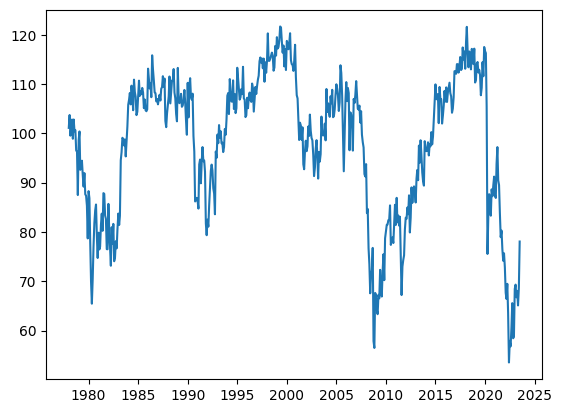

In [31]:
sentiment['DATE'] = pd.to_datetime(sentiment.YYYYMM, format="%Y%m")

sentiment_by_month = sentiment.groupby(['DATE']).ICC.mean()

plt.plot(sentiment_by_month)
plt.show()

In [5]:
unemployment = pd.read_csv("unemployment_rate.csv")
unemployment['DATE'] = pd.to_datetime(unemployment.DATE)
unemployment = unemployment.set_index('DATE')
inflation = pd.read_csv("inflation.csv")
inflation['DATE'] = pd.to_datetime(inflation.DATE)
inflation = inflation.set_index('DATE')
interest_rates = pd.read_csv("interest_rates.csv")
interest_rates['DATE'] = pd.to_datetime(interest_rates['DATE'])
interest_rates = interest_rates.set_index('DATE')

In [22]:
data = pd.DataFrame(data={"sentiment": sentiment_by_month, 
                          "inflation": inflation.CORESTICKM159SFRBATL, 
                          "unemployment": unemployment.UNRATE,
                          "rates": interest_rates.DFF}).dropna()

In [23]:
data['sentiment'] = (data.sentiment - data.sentiment.mean())/data.sentiment.std()
data['unemployment'] = (data.unemployment - data.unemployment.mean())/data.unemployment.std()
data['inflation'] = (data.inflation - data.inflation.mean())/data.inflation.std()
data['rates'] = (data.rates - data.rates.mean())/data.rates.std()

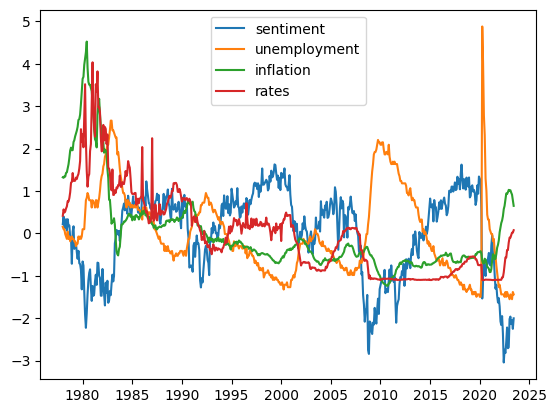

In [24]:
plt.plot(data.sentiment)
plt.plot(data.unemployment)
plt.plot(data.inflation)
plt.plot(data.rates)
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.show()

In [61]:
def try_model(data, form):
    data_precovid = data[data.index < '2020-02-01']
    model_80s = smf.ols(formula=form, data=data, subset=data.index < '1990').fit()
    model_precovid = smf.ols(formula=form, data=data, subset=data.index < '2020-02-01').fit()
    model_full = smf.ols(formula=form, data=data).fit()
    plt.plot(data.sentiment)
    for name, model in zip(["80s", "Pre-Covid", "Full"], [model_80s, model_precovid, model_full]):
        print(f"Model {name}")
        print(model.summary())
        plt.plot(model.predict(data))
    plt.axhline(y = 0, color='lightgrey')
    plt.legend(['sentiment', '80s', 'pre-covid', 'full', 'neutral'])
    plt.title(f"Model {form}")
    plt.show()

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     326.0
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           1.33e-53
Time:                        18:00:21   Log-Likelihood:                -58.253
No. Observations:                 144   AIC:                             122.5
Df Residuals:                     141   BIC:                             131.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.8507      0.046    

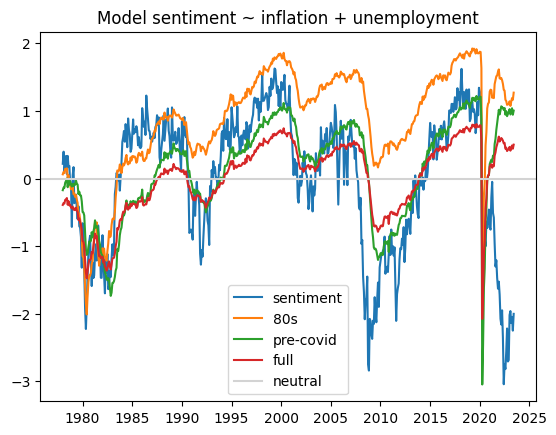

In [62]:
try_model(data, "sentiment ~ inflation + unemployment")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     227.4
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           1.30e-53
Time:                        18:03:49   Log-Likelihood:                -55.122
No. Observations:                 144   AIC:                             118.2
Df Residuals:                     140   BIC:                             130.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.9376      0.057    

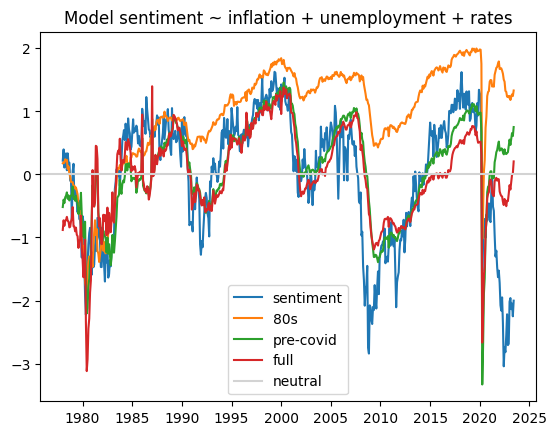

In [64]:
try_model(data, "sentiment ~ inflation + unemployment + rates")

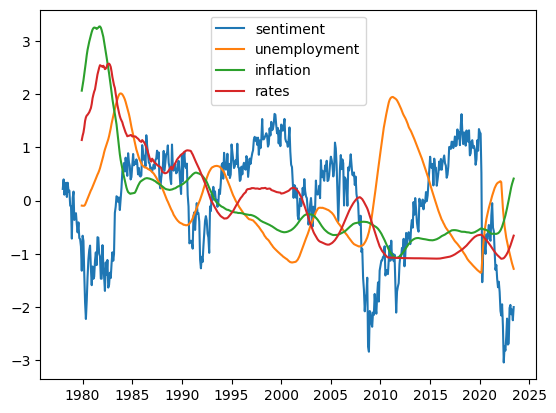

In [12]:
plt.plot(data.sentiment)
plt.plot(data.unemployment.rolling(24).mean())
plt.plot(data.inflation.rolling(24).mean())
plt.plot(data.rates.rolling(24).mean())
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.show()

In [67]:
data['uenmployment_12_month'] = data.unemployment.rolling(12).mean()
data['inflation_12_month'] = data.inflation.rolling(12).mean()
data['rates_12_month'] = data.rates.rolling(12).mean()

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     142.4
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           1.18e-53
Time:                        18:06:35   Log-Likelihood:                -37.017
No. Observations:                 133   AIC:                             88.03
Df Residuals:                     126   BIC:                             108.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

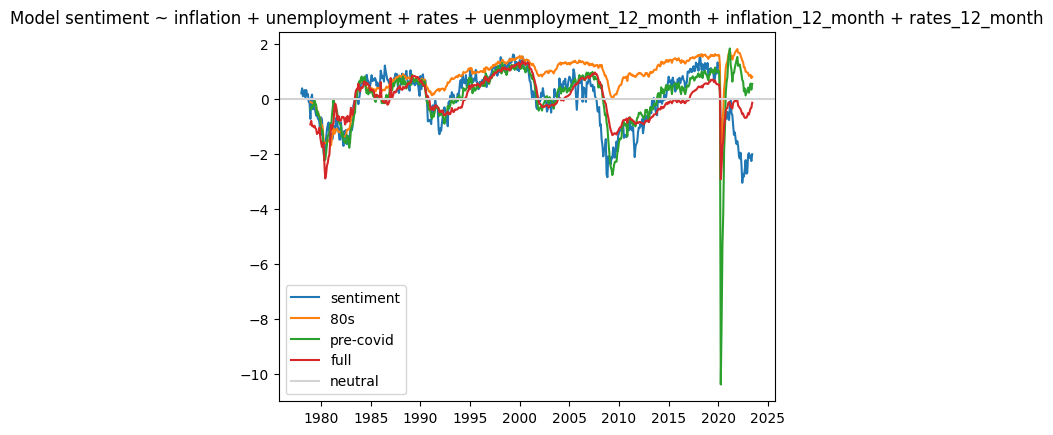

In [68]:
try_model(data, "sentiment ~ inflation + unemployment + rates + uenmployment_12_month + inflation_12_month + rates_12_month")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     168.1
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           3.37e-54
Time:                        18:08:59   Log-Likelihood:                -23.457
No. Observations:                 121   AIC:                             60.91
Df Residuals:                     114   BIC:                             80.48
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept           

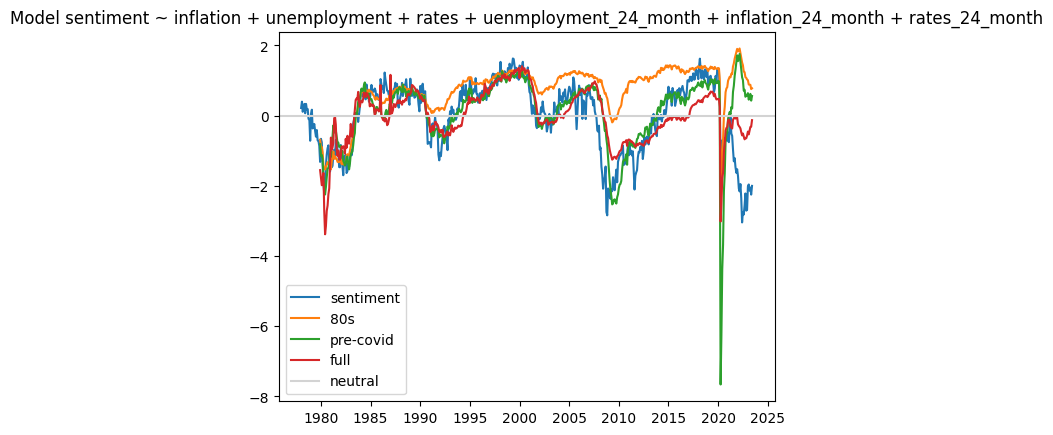

In [70]:
data['uenmployment_24_month'] = data.unemployment.rolling(24).mean()
data['inflation_24_month'] = data.inflation.rolling(24).mean()
data['rates_24_month'] = data.rates.rolling(24).mean()
try_model(data, "sentiment ~ inflation + unemployment + rates + uenmployment_24_month + inflation_24_month + rates_24_month")

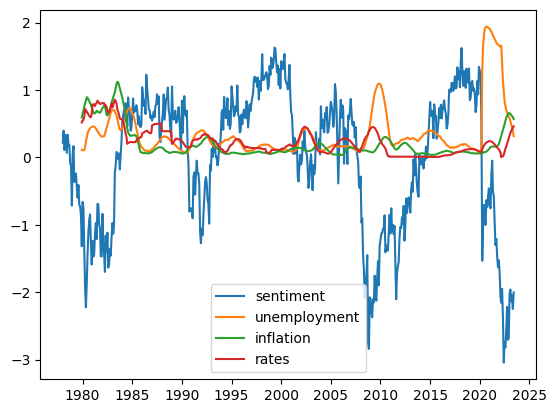

In [16]:
plt.plot(data.sentiment)
plt.plot(data.unemployment.rolling(24).std())
plt.plot(data.inflation.rolling(24).std())
plt.plot(data.rates.rolling(24).std())
plt.legend(['sentiment', 'unemployment', 'inflation', 'rates'])
plt.show()

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                     121.3
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           4.12e-47
Time:                        18:10:26   Log-Likelihood:                -40.858
No. Observations:                 121   AIC:                             95.72
Df Residuals:                     114   BIC:                             115.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

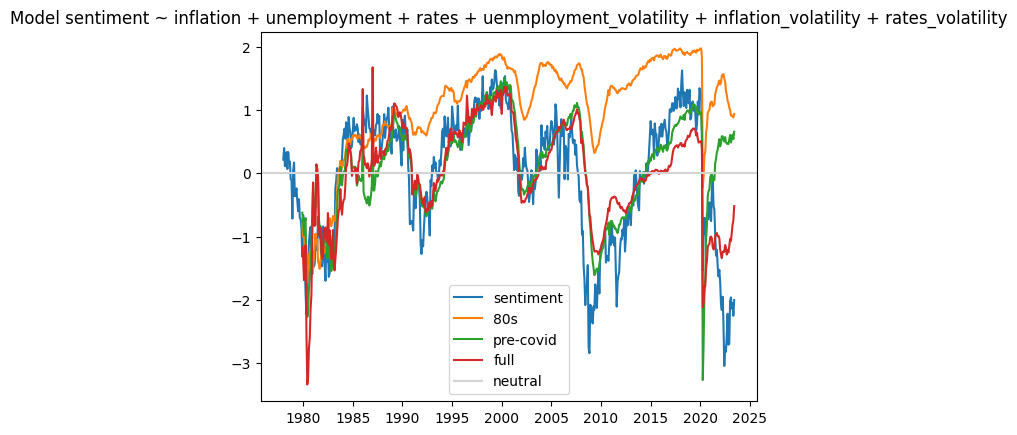

In [72]:
data['uenmployment_volatility'] = data.unemployment.rolling(24).std()
data['inflation_volatility'] = data.inflation.rolling(24).std()
data['rates_volatility'] = data.rates.rolling(24).std()
try_model(data,  "sentiment ~ inflation + unemployment + rates + uenmployment_volatility + inflation_volatility + rates_volatility")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     141.2
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           1.30e-43
Time:                        18:11:36   Log-Likelihood:                -54.754
No. Observations:                 121   AIC:                             119.5
Df Residuals:                     116   BIC:                             133.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

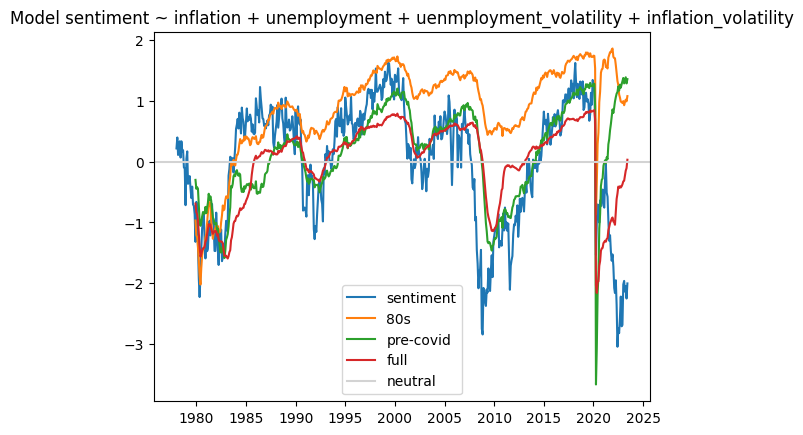

In [73]:
try_model(data,"sentiment ~ inflation + unemployment + uenmployment_volatility + inflation_volatility")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     106.8
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           4.37e-52
Time:                        18:28:59   Log-Likelihood:                -47.850
No. Observations:                 144   AIC:                             111.7
Df Residuals:                     136   BIC:                             135.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Interc

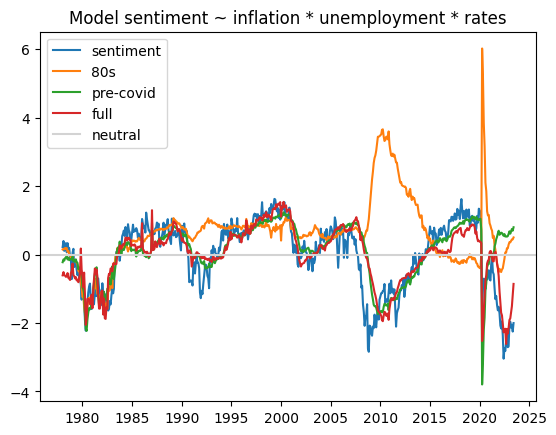

In [80]:
try_model(data, "sentiment ~ inflation * unemployment * rates")

Model 80s
                            OLS Regression Results                            
Dep. Variable:              sentiment   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     119.2
Date:                Mon, 07 Aug 2023   Prob (F-statistic):           7.39e-52
Time:                        18:30:51   Log-Likelihood:                -51.006
No. Observations:                 144   AIC:                             116.0
Df Residuals:                     137   BIC:                             136.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept         

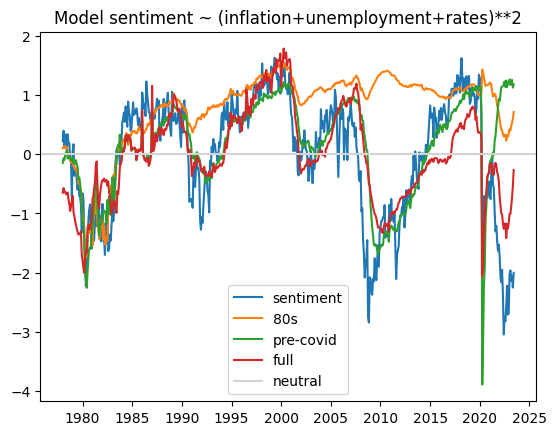

In [82]:
try_model(data, "sentiment ~ (inflation+unemployment+rates)**2")